## Index

1) Importing Libraries
2) Data and it's preprocessing
3) Model
4) Model's 50 lowest confidence score
5) DeepFool
6) Clean Label Backdoor Attack
7) Defense

## Importing Libraries

In [ ]:
import numpy as np
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from art.attacks.poisoning import PoisoningAttackCleanLabelBackdoor, PoisoningAttackBackdoor

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data and it's preprocessing

In [5]:
test = tf.keras.utils.image_dataset_from_directory(r'..\..\7. IMAGENET 256\Test', image_size=(224, 224))

Found 50000 files belonging to 1000 classes.


In [6]:
test_iterator = test.as_numpy_iterator()

In [7]:
test_batch = test_iterator.next()

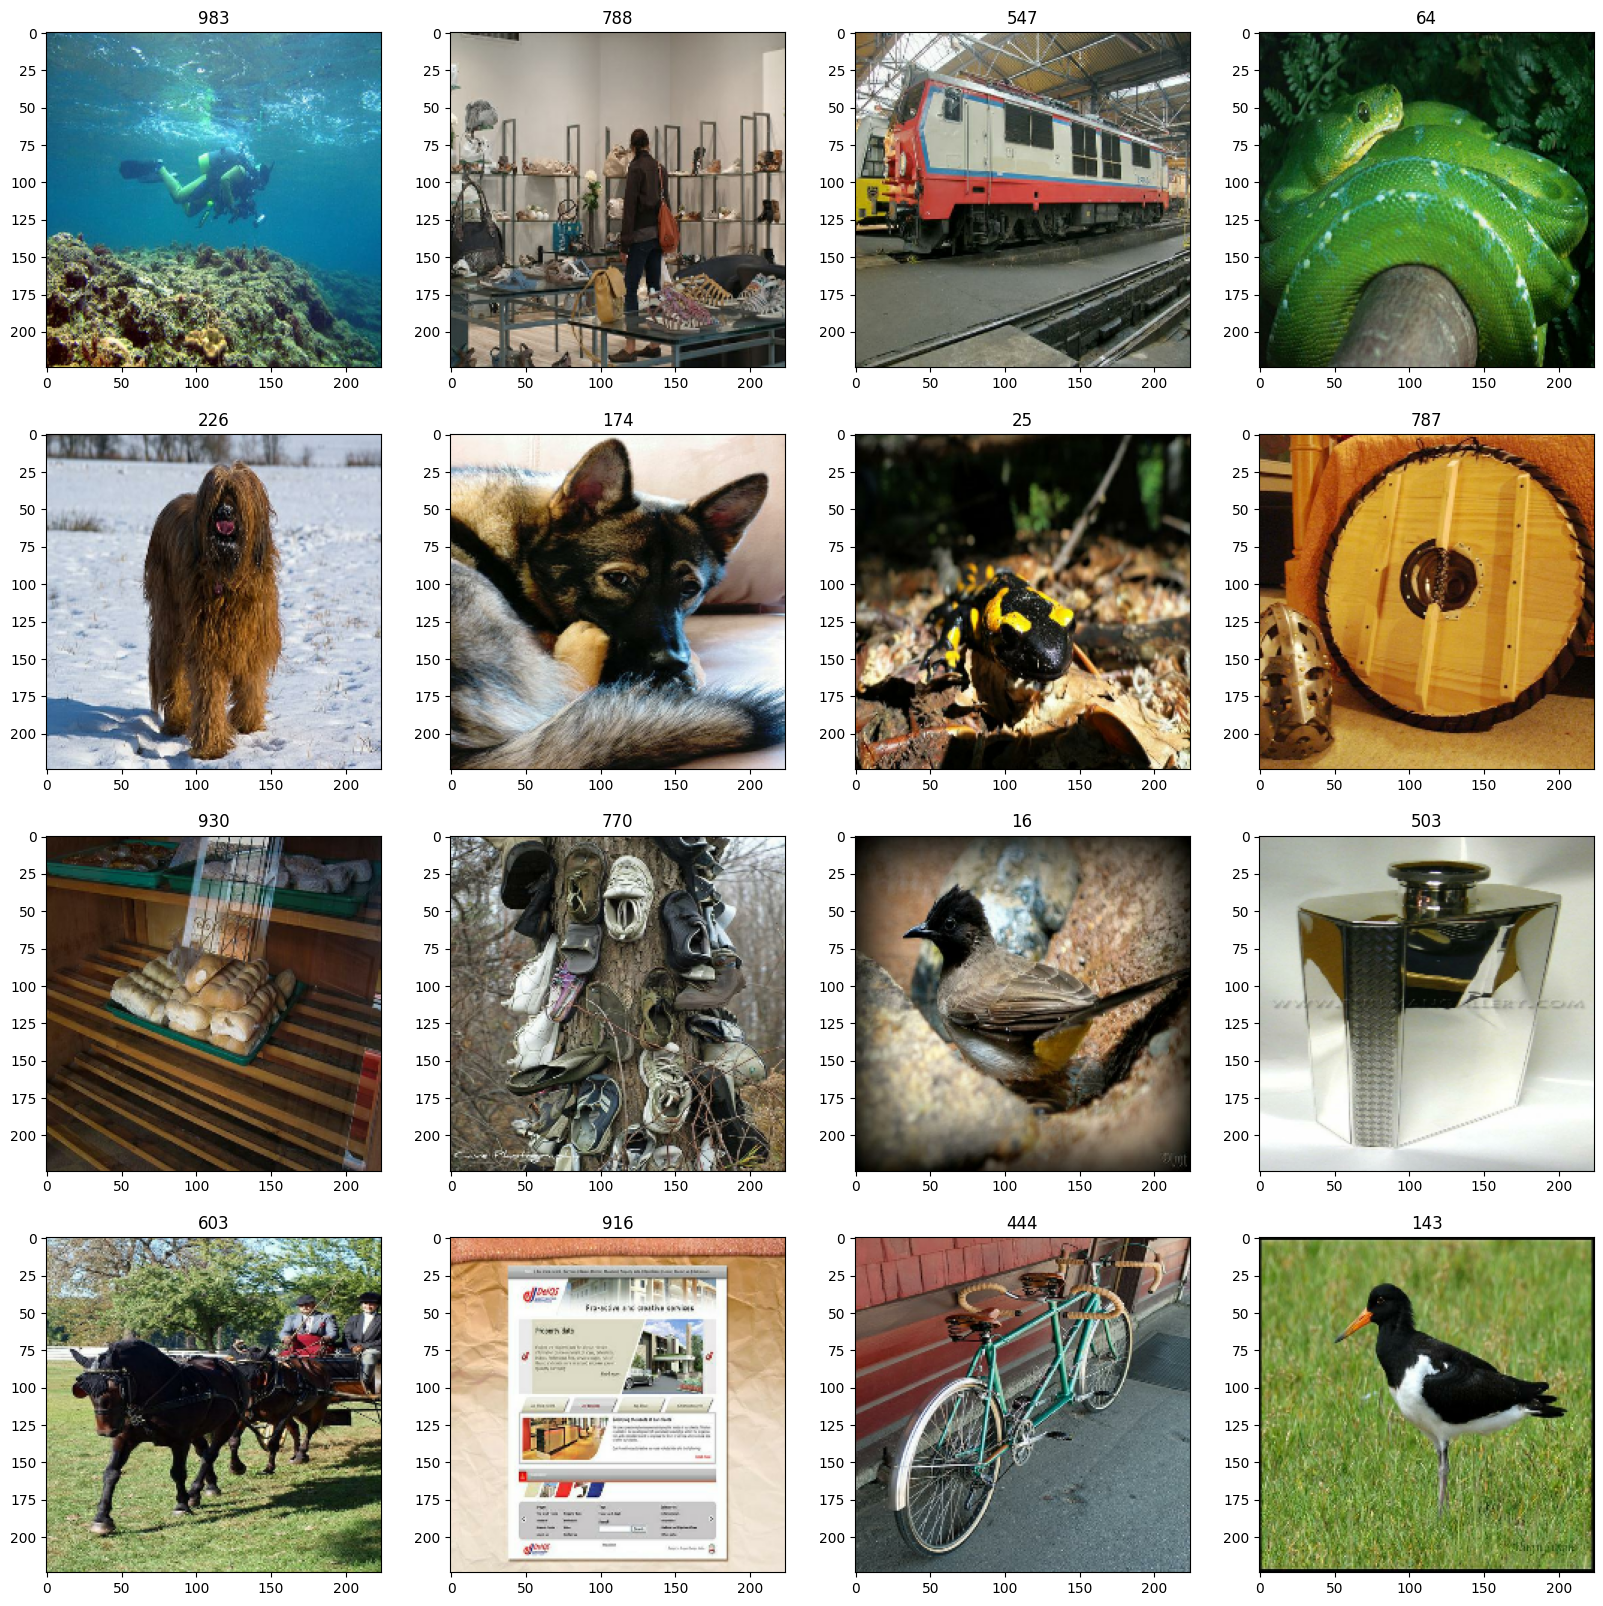

In [8]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))
ax = ax.flatten()
for idx, img in enumerate(test_batch[0][:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(test_batch[1][idx])

In [9]:
test = test.map(lambda x, y: (x/255, y))

In [10]:
test_scaled_iterator = test.as_numpy_iterator()

In [11]:
test_batch = test_scaled_iterator.next()

In [12]:
data = tf.keras.utils.image_dataset_from_directory(r'..\..\7. IMAGENET 256\Train 1', image_size=(224, 224))

Found 639639 files belonging to 1000 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
train_batch = data_iterator.next()

In [15]:
data = data.map(lambda x, y: (x/255, y))

In [16]:
scaled_iterator = data.as_numpy_iterator()

In [17]:
batch = scaled_iterator.next()

In [18]:
train_size = int(len(data) * 0.8)
val_size = len(data) - train_size

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

## Model

In [ ]:
model = tf.keras.models.load_model('model/my_model')

In [ ]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)
model.fit(train, validation_data=val, epochs=1)

In [21]:
from tensorflow.keras.losses import CategoricalCrossentropy

# Define loss function
loss_object = CategoricalCrossentropy()

In [22]:
classifier = TensorFlowV2Classifier(model=model, nb_classes=1000, input_shape=(224, 224, 3), clip_values=(0, 1), loss_object=loss_object, channels_first=False)

## Model's 50 lowest confidence score

In [23]:
predictions = model.predict(test)

In [24]:
confidence_score = np.max(predictions, axis=1)

In [25]:
least_confidence_indices = np.argsort(confidence_score)[:50]

In [26]:
least_confidence_indices = np.array(least_confidence_indices)

In [27]:
import tensorflow as tf

# Convert least_confidence_indices to a set for fast lookup
index_set = tf.constant(least_confidence_indices, dtype=tf.int64)

# Function to filter dataset based on indices
def filter_fn(idx, data):
    return tf.reduce_any(tf.equal(idx, index_set))

# Attach index to dataset
dataset_with_index = test.enumerate()

# Filter dataset to keep only required indices
filtered_dataset = dataset_with_index.filter(filter_fn).map(lambda i, data: data)

# Convert to numpy if needed
least_confidence_data = list(filtered_dataset.as_numpy_iterator())

# Separate images and labels
least_confidence_images = np.array([img for img, label in least_confidence_data])
least_confidence_labels = np.array([label for img, label in least_confidence_data])


In [28]:
least_confidence_images.shape

(1, 32, 224, 224, 3)

In [ ]:
least_confidence_labels[0][3]

In [31]:
original_preds = np.argmax(model.predict(least_confidence_images[0]), axis=1)

# Print comparison
for i in range(32):
    print(f"Image {i}:")
    print(f"Original Label: {least_confidence_labels[0][i]}, "
          f"Original Pred: {original_preds[i]}, ")

Image 0:
Original Label: 701, Original Pred: 701, 
Image 1:
Original Label: 560, Original Pred: 560, 
Image 2:
Original Label: 886, Original Pred: 886, 
Image 3:
Original Label: 993, Original Pred: 993, 
Image 4:
Original Label: 826, Original Pred: 826, 
Image 5:
Original Label: 901, Original Pred: 898, 
Image 6:
Original Label: 386, Original Pred: 386, 
Image 7:
Original Label: 931, Original Pred: 933, 
Image 8:
Original Label: 224, Original Pred: 224, 
Image 9:
Original Label: 801, Original Pred: 801, 
Image 10:
Original Label: 362, Original Pred: 362, 
Image 11:
Original Label: 332, Original Pred: 332, 
Image 12:
Original Label: 331, Original Pred: 331, 
Image 13:
Original Label: 748, Original Pred: 588, 
Image 14:
Original Label: 724, Original Pred: 724, 
Image 15:
Original Label: 27, Original Pred: 27, 
Image 16:
Original Label: 124, Original Pred: 73, 
Image 17:
Original Label: 143, Original Pred: 143, 
Image 18:
Original Label: 7, Original Pred: 7, 
Image 19:
Original Label: 401

In [32]:
original_image = np.expand_dims(least_confidence_images[0][3], axis=0)

In [33]:
original_image.shape

(1, 224, 224, 3)

## DeepFool

In [ ]:
from art.attacks.evasion import DeepFool
# Move model to GPU
with tf.device('/GPU:0'):
    attack = DeepFool(classifier)
    adv_images = attack.generate(original_image) 

DeepFool: 100%|██████████| 1/1 [00:45<00:00, 45.25s/it]


### 

In [ ]:
adv_pred = np.argmax(classifier.predict(adv_images))

(-0.5, 223.5, 223.5, -0.5)

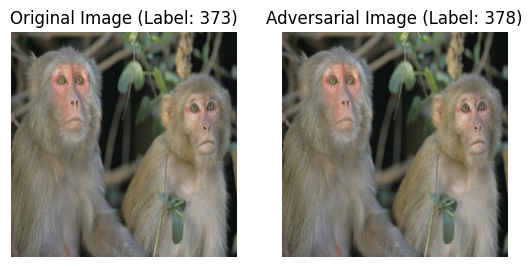

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(least_confidence_images[0][3])
plt.title(f"Original Image (Label: {least_confidence_labels[0][3]})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adv_images[0])
plt.title(f"Adversarial Image (Label: {adv_pred})")
plt.axis("off")

In [ ]:
perturbation = np.mean(np.abs(least_confidence_images[0][3] - adv_images[0]))
print(f"Average perturbation: {perturbation:.10f}")

Average perturbation: 0.0000702761


## Clean Label Backdoor Attack

In [ ]:
x_poison = least_confidence_images[0]
y_poison = least_confidence_labels[0]

In [34]:
print(f"Original image min: {x_poison[1].min()}, max: {x_poison[1].max()}")

Original image min: 0.0, max: 1.0


(-0.5, 223.5, 223.5, -0.5)

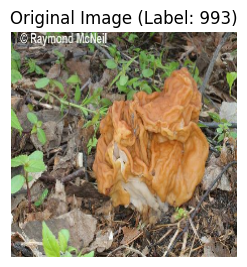

In [35]:
plt.subplot(1, 2, 1)
plt.imshow(least_confidence_images[0][3])
plt.title(f"Original Image (Label: {least_confidence_labels[0][3]})")
plt.axis("off")

In [ ]:
preds = classifier.predict(x_poison)
y_true = np.argmax(preds, axis=1)
preds_one_hot = to_categorical(y_true, num_classes=1000)


In [37]:
preds_one_hot[0].max()

1.0

In [38]:
y_true

array([701, 560, 886, 993, 826, 898, 386, 933, 224, 801, 362, 332, 331,
       588, 724,  27,  73, 143,   7, 898,  54, 173, 842, 440, 939, 565,
       924, 617, 371, 733,  58, 805], dtype=int64)

In [39]:
y_poison

array([701, 560, 886, 993, 826, 901, 386, 931, 224, 801, 362, 332, 331,
       748, 724,  27, 124, 143,   7, 401,  54, 173, 768, 907, 939, 733,
       762, 617, 374, 733,  58, 805])

In [70]:
target_class = y_true[5]
target_one_hot = to_categorical([target_class], num_classes=1000)[0]


In [ ]:
class SimplePatchBackdoor(PoisoningAttackBackdoor):
    def __init__(self, size=20, value=1):
        self.size = size
        self.value = value

    def apply(self, x):
        x_copy = x.copy()
        patch_value = 1 if x_copy.max() <= 1 else 255

        for i in range(x_copy.shape[0]):
            h, w = x_copy.shape[1:3]
            top = np.random.randint(0, h - self.size)
            left = np.random.randint(0, w - self.size)
            x_copy[i, top:top+self.size, left:left+self.size, :] = patch_value

        return x_copy
    
    def perturbation(self, x):
        return self.apply(x)

# Instantiate the backdoor trigger.
backdoor = SimplePatchBackdoor(size=20, value=0)


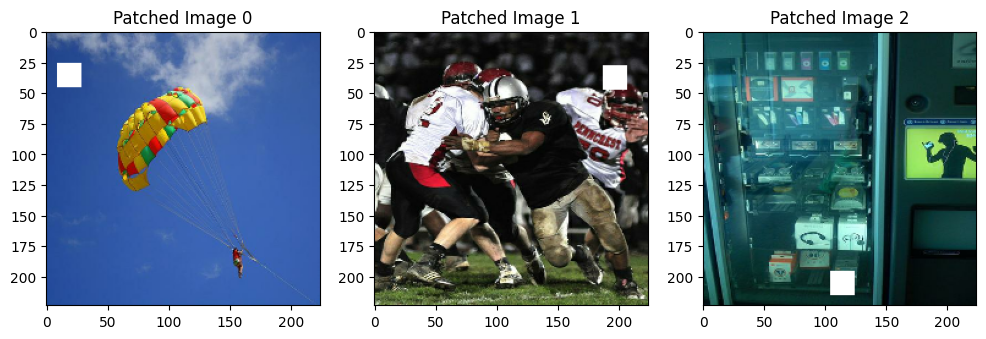

In [ ]:
patched_images = backdoor.apply(x_poison)

# Display multiple images to verify
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(np.clip(patched_images[i], 0, 1))
    ax.set_title(f"Patched Image {i}")
plt.show()

In [ ]:
attack = PoisoningAttackCleanLabelBackdoor(
    backdoor=backdoor,
    proxy_classifier=classifier,
    target=target_one_hot,
    pp_poison=0.9,
    eps=0.3,
    eps_step=0.1,
)


In [76]:
x_poisoned, _ = attack.poison(x_poison, preds_one_hot)

In [84]:
print(f"Original image min: {x_poison[1].min()}, max: {x_poison[1].max()}")
print(f"Poisoned image min: {x_poisoned[1].min()}, max: {x_poisoned[1].max()}")

Original image min: 0.0, max: 1.0
Poisoned image min: 0.0, max: 1.0


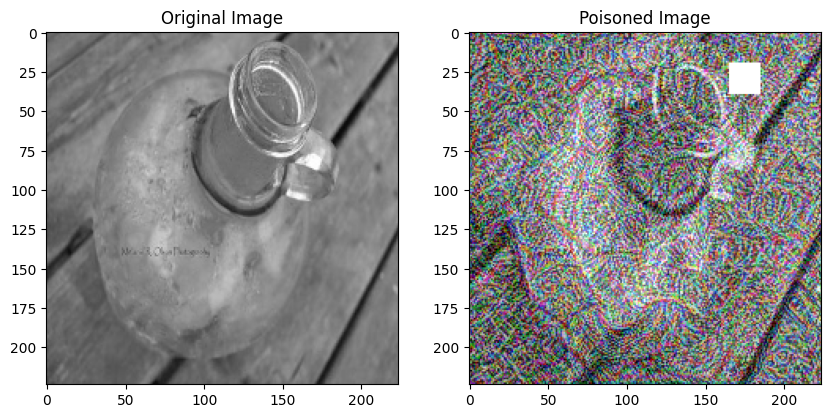

In [83]:
img_original = np.clip(x_poison[5], 0, 1)  # Ensure valid range
img_poisoned = np.clip(x_poisoned[5], 0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img_original)

plt.subplot(1, 2, 2)
plt.title("Poisoned Image")
plt.imshow(img_poisoned)

plt.show()

## Defense

In [30]:
from art.defences.preprocessor import JpegCompression

In [31]:
jpeg_defense = JpegCompression(quality=75, clip_values=(0, 1))

In [ ]:
x_compressed, _ = jpeg_defense(least_confidence_images)

In [41]:
predictions = classifier.predict(least_confidence_images[0])
predicted_labels = np.argmax(predictions, axis=1)
accuracy_adv = np.mean(predicted_labels == least_confidence_labels) * 100
print(f"Accuracy before JPEG Compression data: {accuracy_adv:.2f}%")

Accuracy before JPEG Compression data: 68.75%


In [50]:
predictions = classifier.predict(x_compressed[0])
print("Predictions after JPEG Compression:", np.argmax(predictions, axis=1))

Predictions after JPEG Compression: [185 512  68  41 146  68 327 882 739  77 667 617 884 260 791 668  61  25
 538 185 736 248  73 389 579 750 254 203 750 992 488 945]


In [38]:
predicted_labels = np.argmax(predictions, axis=1)
accuracy_adv = np.mean(predicted_labels == least_confidence_labels) * 100
print(f"Accuracy after JPEG Compression data: {accuracy_adv:.2f}%")

Accuracy after JPEG Compression data: 62.50%


In [ ]:
attack = DeepFool(classifier, batch_size=6)

In [55]:
adv_images = attack.generate(least_confidence_images[0]) 

DeepFool: 100%|██████████| 6/6 [2:39:10<00:00, 1591.79s/it]  


In [56]:
adv_compressed, _ = jpeg_defense(adv_images)

In [60]:
predictions = classifier.predict(adv_images)
predicted_labels = np.argmax(predictions, axis=1)
accuracy_adv = np.mean(predicted_labels == least_confidence_labels[0]) * 100
print(f"Accuracy on Adversarial data: {accuracy_adv:.2f}%")

Accuracy on Adversarial data: 68.75%


In [61]:
predictions = classifier.predict(adv_compressed)
predicted_labels = np.argmax(predictions, axis=1)
accuracy_adv = np.mean(predicted_labels == least_confidence_labels[0]) * 100
print(f"Accuracy on Adversarial data using JPEG Compression data: {accuracy_adv:.2f}%")

Accuracy on Adversarial data using JPEG Compression data: 62.50%
